# HW2 Project: Energy Consumption Data Analysis
Tony Wang 

penn key: tonyw3

Oct. 6, 2024

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox


## Data Import
Here we index power with time in datetime. So we can better analyze the statistics

In [12]:
data_path = 'midatl_forecast_load_mw_hourly_averaged_integer.csv'

energy_data = pd.read_csv(data_path)

energy_data.head()


,date,hour,forecast_load_mw
0,2024-01-01,0,27032
1,2024-01-01,1,26262
2,2024-01-01,2,25874
3,2024-01-01,3,25731
4,2024-01-01,4,25827


In [13]:
# Merge data and hour into datatime as time index
energy_data['datetime'] = pd.to_datetime(energy_data['date']) + pd.to_timedelta(energy_data['hour'], unit='h')
energy_data.drop(columns=['date', 'hour'], inplace=True)
energy_data.set_index('datetime', inplace=True)

energy_data.head()


,forecast_load_mw
datetime,
2024-01-01 00:00:00,27032
2024-01-01 01:00:00,26262
2024-01-01 02:00:00,25874
2024-01-01 03:00:00,25731
2024-01-01 04:00:00,25827


## Seasonal-Trend Decomposition
Very simple with two lines of code

In [14]:
# STL in 24-hour cycle
stl = STL(energy_data['forecast_load_mw'], period=24, robust=True)
stl_result = stl.fit()


## Plot and Analyze the Components


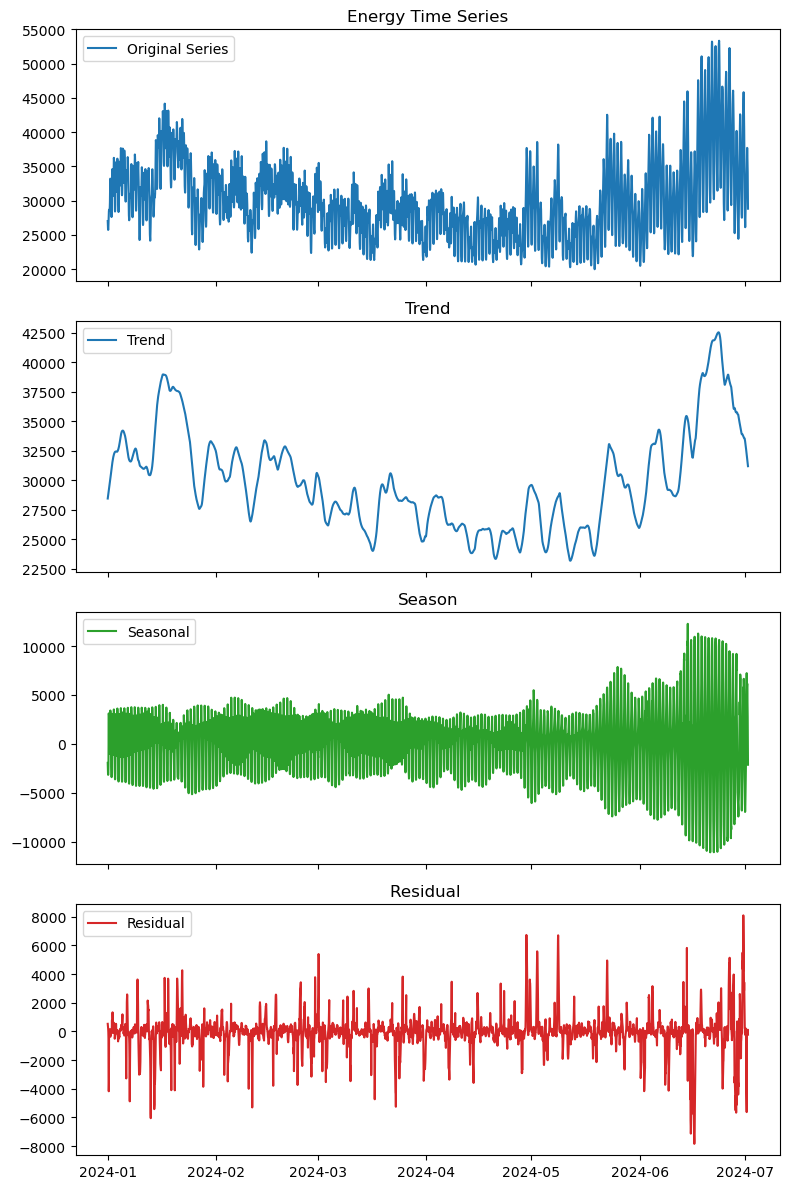

In [19]:

# PlotTrend, Seasonal, and Residual
fig, axes = plt.subplots(4, 1, figsize=(8, 12), sharex=True)

axes[0].plot(energy_data.index, energy_data['forecast_load_mw'], label='Original Series')
axes[0].set_title('Energy Time Series')
axes[0].legend()

axes[1].plot(energy_data.index, stl_result.trend, label='Trend', color='tab:blue')
axes[1].set_title('Trend')
axes[1].legend()

axes[2].plot(energy_data.index, stl_result.seasonal, label='Seasonal', color='tab:green')
axes[2].set_title('Season')
axes[2].legend()

axes[3].plot(energy_data.index, stl_result.resid, label='Residual', color='tab:red')
axes[3].set_title('Residual ')
axes[3].legend()

plt.tight_layout()
plt.show()


### Analysis of STL Decomposition:

1. **Original Series**:
   - The data shows daily fluctuations with notable peaks towards June 2024, likely due to seasonal factors (e.g., increased cooling demand in warmer months).

2. **Trend**:
   - A gradual increase is observed, especially in late spring/early summer, indicating rising energy demand. Early months (Jan-Apr) show more stable consumption, likely tied to lower demand in colder weather.

3. **Seasonal**:
   - Strong daily periodicity (T=24h) reflects predictable human activity patterns. Amplitude increases towards summer, suggesting greater intra-day variability as overall consumption rises.

4. **Residuals**:
   - Spikes indicate short-term anomalies, potentially driven by external factors (e.g., weather events or holidays). 



## Autocorrelation Analysis

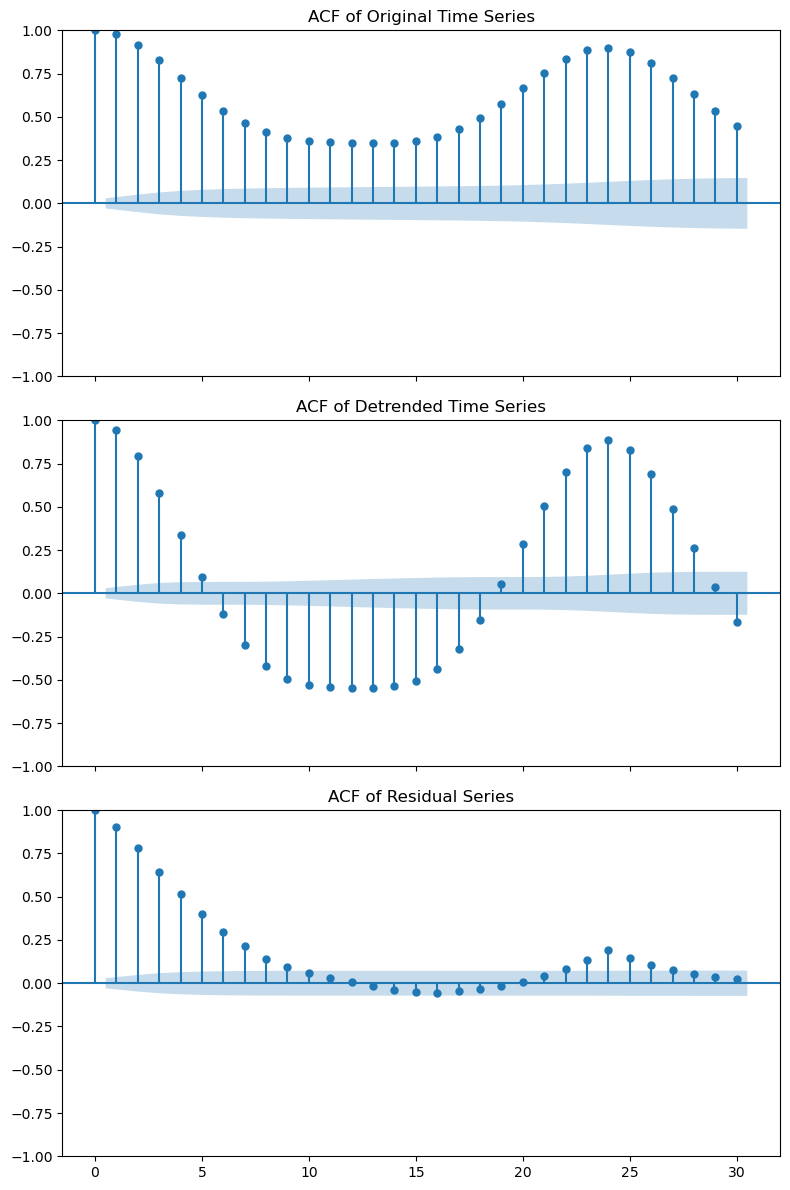

In [18]:

# Plot ACF for original, detrended, and residual series
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Original series ACF
plot_acf(energy_data['forecast_load_mw'], lags=30, ax=axes[0])
axes[0].set_title('ACF of Original Time Series')

# Detrended series ACF (original - trend) 
detrended = energy_data['forecast_load_mw'] - stl_result.trend
plot_acf(detrended.dropna(), lags=30, ax=axes[1])
axes[1].set_title('ACF of Detrended Time Series')

# Residual series ACF
plot_acf(stl_result.resid.dropna(), lags=30, ax=axes[2])
axes[2].set_title('ACF of Residual Series')

plt.tight_layout()
plt.show()


### ACF Analysis:

1. **Original Series**:
   - Strong autocorrelation across lags suggests great temporal dependencies, likely due to daily cycles.

2. **Detrended Series**:
   - Reduced periodicity, indicating that much of the autocorrelation was driven by seasonality, though some remains.

3. **Residuals**:
   - Most autocorrelation is removed, with weak remaining dependencies, implying the STL decomposition effectively isolated trend and seasonality.

These implies that temporal dependencies are mostly removed after decomposition; residuals are close to white noise with minor remaining structure.

## Ljung-Box Test

In [17]:
ljung_box_results = acorr_ljungbox(stl_result.resid.dropna(), lags=30, return_df=True)

# Display the Ljung-Box test results
print(ljung_box_results.head())

# Extract p-values
p_values = ljung_box_results['lb_pvalue']
print(f"mean of p-values: {p_values.mean():.4f}")
# Check if any p-value is less than 0.05 (5% significance level)
significant_autocorrelation = any(p_value < 0.05 for p_value in p_values)

print(f"\nSignificant autocorrelation remains: {significant_autocorrelation}")
print(f"Minimum p-value: {p_values.min():.4f}")
print(f"Maximum p-value: {p_values.max():.4f}")


       lb_stat  lb_pvalue
1  3585.366875        0.0
2  6254.064823        0.0
3  8078.588099        0.0
4  9244.854455        0.0
5  9951.344375        0.0
mean of p-values: 0.0000

Significant autocorrelation remains: True
Minimum p-value: 0.0000
Maximum p-value: 0.0000


### Interpretation:
The Ljung-Box test indicates that there are great amount of autocorrelation in the residuals.

The white noise hypothesis is rejected.

This suggests that the STL decomposition may not have captured all the structure in the data.
For forecasting, this implies that there might be additional patterns or dependencies
that could be exploited to improve predictions.

## Summary

In total, we did succssfully STL power analysis on the given energy data. 

The trend module behaves correctly, and there might be slighly mismatch on the seasonality and residual, but the overall tendency indicate the shift direction of given time series. 

ACF analysis + Ljung Box Test further prove the relationship between seasonality and residual, which could potentially filtered by more advanced algorithm and method. 

All in all, our result could be feature reflecting the system.